# Imaging & Multimedia Assignment 4
Cy Westbrook / cww45  
11 November 2025

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
import pickle

In [46]:
import os
image_names = [ f.split('.')[0] for f in os.listdir('images') if f.endswith('.bmp') ]
image_filenames = { name: os.path.join('images', f"{name}.bmp") for name in image_names }

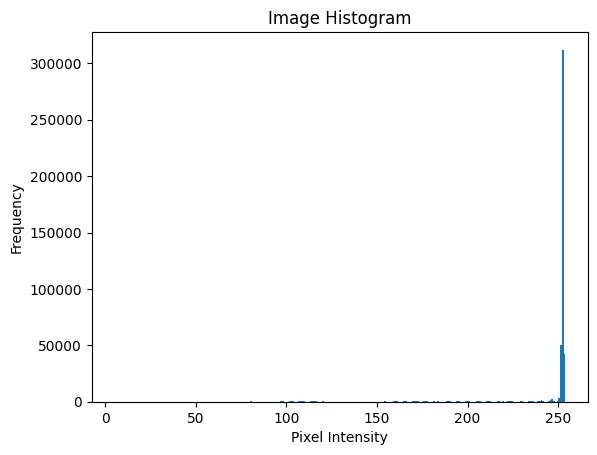

In [47]:
imgs = { name: cv2.imread(image_filenames[name], cv2.IMREAD_GRAYSCALE) for name in image_names }

plt.hist(imgs['a'].ravel(), 256)
plt.title('Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

From the hisogram above, we can see that a threshold around 240 should be fine for binarizing the images.

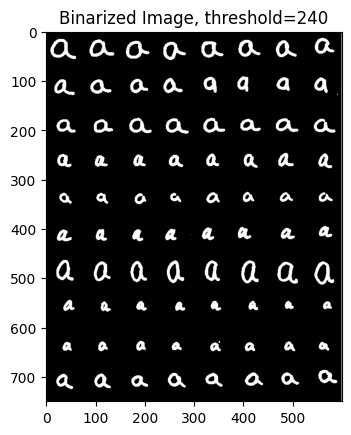

In [48]:
human_threshold = 240

# show image binarized with human threshold
_, thresh_img_human = cv2.threshold(imgs['a'], human_threshold, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh_img_human, cmap='gray')
plt.title(f'Binarized Image, threshold={human_threshold}')
plt.show()

Otsu threshold value: 192.0


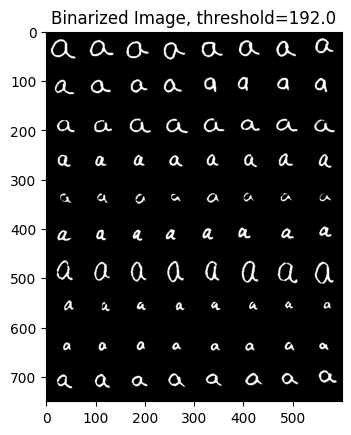

In [49]:
otsu_threshold, thresh_img = cv2.threshold(imgs['a'], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print(f"Otsu threshold value: {otsu_threshold}")
plt.imshow(thresh_img, cmap='gray')
plt.title(f'Binarized Image, threshold={otsu_threshold}')
plt.show()

We'll use the Otsu threshold value.

In [50]:
th_for_all = otsu_threshold
binarized_imgs = { name: cv2.threshold(imgs[name], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] for name in image_names }

- The difference between `THRESH_BINARY_INV` and `THRESH_BINARY` is that one turns pixels above the value white and the other turns them black. Since our original image is black on white instead of white on black we need to use the inverted version.
- Otsu's algorithm tries to statistically determine the threshold that will maximize the variance between the white and black pixel bins to automatically select the best threshold.
- `+` is used because we are passing binary flags, they are numbers with one bit enabled so when we sum them we just get a number with both bits enables and this tells opencv what to do

!! Small Component 38: Area=2, BBox=(562, 329, 2, 1)


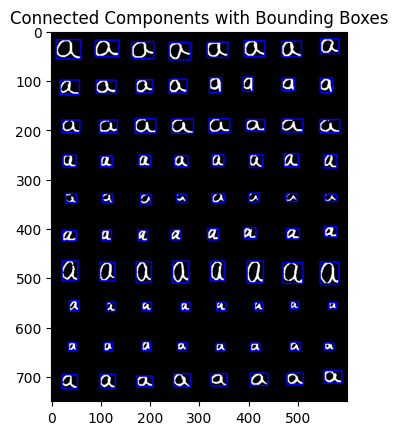

In [51]:
labels_for_img = {name: cv2.connectedComponentsWithStats(binarized_imgs[name], connectivity=8) for name in image_names}
num_labels, label_map, stats, centroids = labels_for_img['a']

small_area_threshold = 50
small_areas = []

# draw bounding boxes around connected components
output_img = cv2.cvtColor(binarized_imgs['a'], cv2.COLOR_GRAY2BGR)
for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]
    area_is_small = area < small_area_threshold
    if area_is_small:
        print(f"!! Small Component {i}: Area={area}, BBox=({x}, {y}, {w}, {h})")
        small_areas.append(i)
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0) if area_is_small else (0, 0, 255), 2)
plt.imshow(output_img)
plt.title('Connected Components with Bounding Boxes')

plt.show()

In [52]:
features_for_img = {}
for name in image_names:
    num_labels, label_map, stats, centroids = labels_for_img[name]
    features_for_img[name] = []
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label]
        if area < small_area_threshold:
            continue
        roi = imgs['a'][y:y+h, x:x+w]
        moments = cv2.moments(roi)
        features_for_img[name].append(cv2.HuMoments(moments).flatten())

In [53]:
features = []
labels = []
for name in image_names:
    if name == 'test':
        continue
    for feature in features_for_img[name]:
        features.append(feature)
        labels.append(name)

In [54]:
# save labels and features to pickle files
with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [55]:
# load labels and features from pickle files
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [56]:
features = np.array(features)
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)
features_norm = (features - mean) / std

We need to normalize the features so that one feature does not outweight another just because its absolute values are larger. We want to ensure that all features have the same "weight" no matter the scale that they are represented on.

In [57]:
D = cdist(features, features)

In [58]:
D_index = np.argsort(D, axis=1)

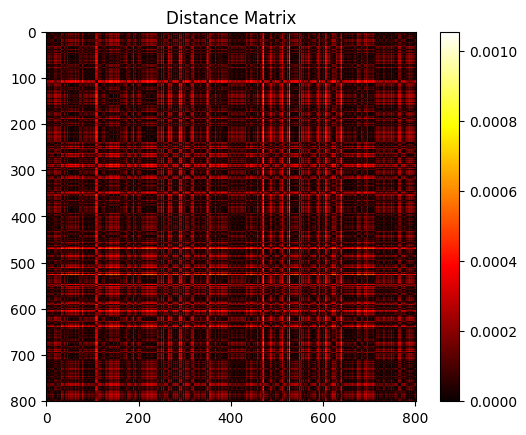

In [59]:
# visualize the distance matrix
plt.imshow(D, cmap='hot', interpolation='nearest')
plt.title('Distance Matrix')
plt.colorbar()
plt.show()

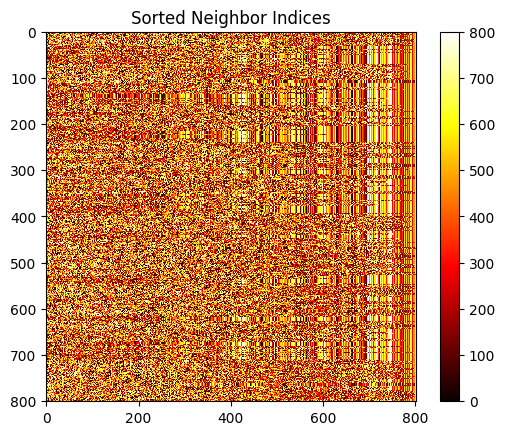

In [60]:
plt.imshow(D_index, cmap='hot', interpolation='nearest')
plt.title('Sorted Neighbor Indices')
plt.colorbar()
plt.show()

In [61]:
# predict class of nearest neighbor and compare with true label
y_true = []
y_pred = []
for i in range(len(labels)):
    y_true.append(labels[D_index[i, 0]])
    y_pred.append(labels[D_index[i, 1]])

In [62]:
# show recognition rate as %
correct = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        correct += 1
accuracy = correct / len(y_true) * 100
print(f"Recognition Rate: {accuracy:.2f}%")

Recognition Rate: 14.48%


In [63]:
confM = confusion_matrix(y_true, y_pred, labels=image_names)
print("Confusion Matrix:")
print(confM)

Confusion Matrix:
[[11 10  5  5 11 15  0  7  5  4  7]
 [ 8 18  4  7  9  5  0  4  7  8 10]
 [ 6  3 12  8  8 12  0  3 10 10  8]
 [ 6  8 11  9  3  3  0 11 12  7 10]
 [ 9 14 10  8 10  3  0  5  4 14  4]
 [12  4 14  6  4  3  0  6  8 14  8]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 7  7  5 11  4  6  0 14  7  5 14]
 [ 9  9  8 10  9  9  0  9  8  3  6]
 [ 6 10  9  7 16  9  0  4  3 12  5]
 [ 6  9  5  8  2  3  0 15  7  6 19]]


In [64]:
# we already did basically all the processing for test, just need to make the array
test_features = features_for_img['test']
# use mean and std from before, don't recompute
test_features = (test_features - mean) / std

We have to use the normalization from the training, since otherwise the new data will be "misaligned" with the test data. Since we are trying to compute distances, it is critical that the position (in feature space) be computed correctly and shifted and scaled by the same amount that we scaled the training data.

In [65]:
D_test = cdist(test_features, features_norm)
D_test_index = np.argsort(D_test, axis=1)

In [66]:
# make predictions for test set
y_pred = []
for i in range(len(test_features)):
    y_pred.append(labels[D_test_index[i, 0]])

In [67]:
# Load ground truth
with open('test_gt.pkl', 'rb') as f:
    gt = pickle.load(f)
    classes = gt[b'classes']
    locations = gt[b'locations']

# Set these to your Section 4.1 variable names
# Your test image stats variable
test_stats = labels_for_img['test'][2]
# Your test predictions variable
test_predictions = y_pred

# Handle label type mismatch: ground truth is strings, predictions might be integers
if len(test_predictions) > 0 and isinstance(test_predictions[0], (int, np.integer)):
    test_predictions = [chr(label) for label in test_predictions]

correct = 0
total = 0

for gt_label, (cy, cx) in zip(classes, locations):
    for i in range(1, len(test_stats)):  # Skip background (stats[0])
        x, y, w, h, area = test_stats[i]
        
        if x <= cx < x + w and y <= cy < y + h:
            total += 1
            
            if i-1 < len(test_predictions):
                if str(test_predictions[i-1]) == str(gt_label):
                    correct += 1
            break

if total > 0:
    rate = 100 * correct / total
    print(f"Recognition rate: {rate:.2f}% ({correct}/{total})")
else:
    print("No matches found")

Recognition rate: 30.23% (13/43)
